In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

c:\Users\tiago\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\tiago\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import os
import warnings

warnings.filterwarnings("ignore") 

In [3]:
from darts import TimeSeries
from darts.dataprocessing.pipeline import Pipeline
from darts.models import TiDEModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import StaticCovariatesTransformer, MissingValuesFiller

In [4]:
TIME_COL = "Date"
TARGET = "Weekly_Sales"
STATIC_COV = ["Store", "Dept", "Type", "Size"]
DYNAMIC_COV_FILL_0 = ["IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
DYNAMIC_COV_FILL_INTERPOLATE = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
FREQ = "W-FRI"
FORECAST_HORIZON = 16 # weeks
SCALER = Scaler()
TRANSFORMER = StaticCovariatesTransformer()
PIPELINE = Pipeline([SCALER, TRANSFORMER])

In [5]:
df = pd.read_csv('data/train.csv')
store_info = pd.read_csv('data/stores.csv')
exo_feat = pd.read_csv('data/features.csv').drop(columns='IsHoliday')

In [6]:
# join all data frames
df = pd.merge(df, store_info, on=['Store'], how='left')
df = pd.merge(df, exo_feat, on=['Store', TIME_COL], how='left')

In [7]:
df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df[TARGET] = np.where(df[TARGET] < 0, 0, df[TARGET]) # remove negative values
df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']].fillna(0) # fill missing values with nan
df["IsHoliday"] = df["IsHoliday"]*1 # convert boolean into binary
df["Size"] = np.where(df["Size"] < store_info["Size"].quantile(0.25), "small",
                np.where(df["Size"] > store_info["Size"].quantile(0.75), "large",
"medium")) # make size a categorical variable

In [ ]:
df['id']=df['Store'].astype(str) + '-'+ df['Dept'].astype(str)

df.groupby('id').agg({'Date':'count'}).reset_index().sort_values(by='Date')

result = df.groupby('id').agg({'Date':'count'}).reset_index()
result = result[result['Date'] == 143].sort_values(by='Date')
result

In [9]:
df = df[df['id'].isin(result['id'])]
# reduce running time by forecasting only top 7 stores
top_7_stores = df.groupby(['Store']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET, ascending=False).head(7)
df = df[df['Store'].isin(top_7_stores['Store'])]

In [10]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,id
10244,2,1,2010-02-05,35034.06,0,A,medium,40.19,2.572,0.00,0.00,0.00,0.00,0.00,210.752605,8.324,2-1
10245,2,1,2010-02-12,60483.70,1,A,medium,38.49,2.548,0.00,0.00,0.00,0.00,0.00,210.897994,8.324,2-1
10246,2,1,2010-02-19,58221.52,0,A,medium,39.69,2.514,0.00,0.00,0.00,0.00,0.00,210.945160,8.324,2-1
10247,2,1,2010-02-26,25962.32,0,A,medium,46.10,2.561,0.00,0.00,0.00,0.00,0.00,210.975957,8.324,2-1
10248,2,1,2010-03-05,27372.05,0,A,medium,47.17,2.625,0.00,0.00,0.00,0.00,0.00,211.006754,8.324,2-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266938,27,98,2012-09-28,9696.08,0,A,large,64.92,4.158,26306.03,39.82,55.24,11296.93,12954.12,142.765750,8.239,27-98
266939,27,98,2012-10-05,9936.23,0,A,large,64.50,4.151,16670.04,0.00,40.02,5385.32,6733.38,142.851683,8.000,27-98
266940,27,98,2012-10-12,11374.41,0,A,large,55.40,4.186,2177.62,0.00,7.22,863.01,7931.82,142.937617,8.000,27-98
266941,27,98,2012-10-19,10955.07,0,A,large,56.53,4.153,2639.32,0.00,4.77,575.48,3147.23,142.863363,8.000,27-98


In [11]:
TiDE_params = {
    "input_chunk_length": 12,  # number of weeks to lookback
    "output_chunk_length": 8,
    "num_encoder_layers": 4,
    "num_decoder_layers": 8,
    "decoder_output_dim": 8,
    "hidden_size": 8,
    "temporal_width_past": 16,
    "temporal_width_future": 8,
    "temporal_decoder_hidden": 128,
    "dropout": 0.2,
    "batch_size": 16,
    "n_epochs": 20,
    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    "random_state": 42,
    "use_static_covariates": True,
    "optimizer_kwargs": {"lr": 0.001},
    "use_reversible_instance_norm": False,
}

In [12]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,id
10244,2,1,2010-02-05,35034.06,0,A,medium,40.19,2.572,0.0,0.0,0.0,0.0,0.0,210.752605,8.324,2-1
10245,2,1,2010-02-12,60483.70,1,A,medium,38.49,2.548,0.0,0.0,0.0,0.0,0.0,210.897994,8.324,2-1
10246,2,1,2010-02-19,58221.52,0,A,medium,39.69,2.514,0.0,0.0,0.0,0.0,0.0,210.945160,8.324,2-1
10247,2,1,2010-02-26,25962.32,0,A,medium,46.10,2.561,0.0,0.0,0.0,0.0,0.0,210.975957,8.324,2-1
10248,2,1,2010-03-05,27372.05,0,A,medium,47.17,2.625,0.0,0.0,0.0,0.0,0.0,211.006754,8.324,2-1


In [13]:
def transform_predictions_to_pandas(predictions: list, ids_list: list, target: str, quantiles: list) -> pd.DataFrame:
    """
    Receives as list of predictions and transform it in a data frame
    Args:
        predictions (list): list with predictions
        pred_list (list): list with test df to extract time series id
    Returns
        pd.DataFrame: data frame with date, forecast, forecast_lower, forecast_upper and id
    """

    pred_df_list = []

    for p, pdf in zip(predictions, ids_list):
        temp = (
            p.quantile_df(quantiles[1])
            .reset_index()
            .rename(columns={f"{target}_{quantiles[1]}": "forecast"})
        )
        temp["forecast_lower"] = p.quantile_df(quantiles[0]).reset_index()[
            f"{target}_{quantiles[0]}"
        ]
        temp["forecast_upper"] = p.quantile_df(quantiles[2]).reset_index()[
            f"{target}_{quantiles[2]}"
        ]

        # add series id
        temp["id"] = pdf

        # convert negative predictions into 0
        temp[["forecast", "forecast_lower", "forecast_upper"]] = temp[
            ["forecast", "forecast_lower", "forecast_upper"]
        ].clip(lower=0)

        pred_df_list.append(temp)

    return pd.concat(pred_df_list)

In [ ]:
train = df[df[TIME_COL] <= (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]
test = df[df[TIME_COL] > (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]

print(train.head())

dynamic_covariates = []
train_darts=[]
lista_id=[]
for i in train['id'].unique():
    lista_id.append(i)
    static_covariates_df = df[df['id'] == i][STATIC_COV].drop_duplicates()

    serie=TimeSeries.from_dataframe(
        df=train[train['id']==i],
        static_covariates=static_covariates_df,
        time_col=TIME_COL,
        value_cols=TARGET,
        freq=FREQ,
        fill_missing_dates=True,
        fillna_value=0
    
    )
    
    train_darts.append(serie)
    print(static_covariates_df)
    print(train_darts)
    

    covariate = datetime_attribute_timeseries(
        serie,
        attribute="month",
        one_hot=True,
        cyclic=False,
        add_length=FORECAST_HORIZON,
    ).stack(
        datetime_attribute_timeseries(
            serie,
            attribute="week",
            one_hot=True,
            cyclic=False,
            add_length=FORECAST_HORIZON,
        )
    )

    covariate = covariate.stack(
        TimeSeries.from_dataframe(
            df[(df['id'] == i)],
            time_col=TIME_COL,
            value_cols=DYNAMIC_COV_FILL_0,
            freq=FREQ,
            fill_missing_dates=True,
            fillna_value=0
        )
    )

    dyn_cov_interp = TimeSeries.from_dataframe(
        df[(df['id'] == i)],
        time_col=TIME_COL,
        value_cols=DYNAMIC_COV_FILL_INTERPOLATE,
        freq=FREQ,
        fill_missing_dates=True
    )
    covariate = covariate.stack(MissingValuesFiller().transform(dyn_cov_interp))

    dynamic_covariates.append(covariate)

dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)
data_transformed = PIPELINE.fit_transform(train_darts)

tide_model = TiDEModel(**TiDE_params)
tide_model.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)

pred = PIPELINE.inverse_transform(tide_model.predict(n=FORECAST_HORIZON, series=data_transformed, num_samples=50, future_covariates=dynamic_covariates_transformed))
pred_df_default=transform_predictions_to_pandas(pred,lista_id,TARGET,[0.25, 0.5, 0.75])


In [15]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,id
10244,2,1,2010-02-05,35034.06,0,A,medium,40.19,2.572,0.0,0.0,0.0,0.0,0.0,210.752605,8.324,2-1
10245,2,1,2010-02-12,60483.70,1,A,medium,38.49,2.548,0.0,0.0,0.0,0.0,0.0,210.897994,8.324,2-1
10246,2,1,2010-02-19,58221.52,0,A,medium,39.69,2.514,0.0,0.0,0.0,0.0,0.0,210.945160,8.324,2-1
10247,2,1,2010-02-26,25962.32,0,A,medium,46.10,2.561,0.0,0.0,0.0,0.0,0.0,210.975957,8.324,2-1
10248,2,1,2010-03-05,27372.05,0,A,medium,47.17,2.625,0.0,0.0,0.0,0.0,0.0,211.006754,8.324,2-1


In [ ]:
datasets_3 = {}

for feature in STATIC_COV:

    new_static_cov = [f for f in STATIC_COV if f != feature]

    print(feature)

    train = df[df[TIME_COL] <= (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]
    test = df[df[TIME_COL] > (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]

    dynamic_covariates = []
    train_darts=[]
    lista_id=[]
    for i in train['id'].unique():
        lista_id.append(i)
        static_covariates_df = df[df['id'] == i][new_static_cov].drop_duplicates()

        serie=TimeSeries.from_dataframe(
            df=train[train['id']==i],
            static_covariates=static_covariates_df,
            time_col=TIME_COL,
            value_cols=TARGET,
            freq=FREQ,
            fill_missing_dates=True,
            fillna_value=0
        
        )
        
        train_darts.append(serie)
        print(static_covariates_df)
        

        covariate = datetime_attribute_timeseries(
            serie,
            attribute="month",
            one_hot=True,
            cyclic=False,
            add_length=FORECAST_HORIZON,
        ).stack(
            datetime_attribute_timeseries(
                serie,
                attribute="week",
                one_hot=True,
                cyclic=False,
                add_length=FORECAST_HORIZON,
            )
        )

        covariate = covariate.stack(
            TimeSeries.from_dataframe(
                df[(df['id'] == i)],
                time_col=TIME_COL,
                value_cols=DYNAMIC_COV_FILL_0,
                freq=FREQ,
                fill_missing_dates=True,
                fillna_value=0
            )
        )

        dyn_cov_interp = TimeSeries.from_dataframe(
            df[(df['id'] == i)],
            time_col=TIME_COL,
            value_cols=DYNAMIC_COV_FILL_INTERPOLATE,
            freq=FREQ,
            fill_missing_dates=True
        )
        covariate = covariate.stack(MissingValuesFiller().transform(dyn_cov_interp))

        dynamic_covariates.append(covariate)

    dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)
    data_transformed = PIPELINE.fit_transform(train_darts)

    tide_model = TiDEModel(**TiDE_params)
    tide_model.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)

    pred = PIPELINE.inverse_transform(tide_model.predict(n=FORECAST_HORIZON, series=data_transformed, num_samples=50, future_covariates=dynamic_covariates_transformed))
    pred_df=transform_predictions_to_pandas(pred,lista_id,TARGET,[0.25, 0.5, 0.75])

    datasets_3[f'new_dataset_{feature}'] = pred_df

In [17]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,id
10244,2,1,2010-02-05,35034.06,0,A,medium,40.19,2.572,0.0,0.0,0.0,0.0,0.0,210.752605,8.324,2-1
10245,2,1,2010-02-12,60483.70,1,A,medium,38.49,2.548,0.0,0.0,0.0,0.0,0.0,210.897994,8.324,2-1
10246,2,1,2010-02-19,58221.52,0,A,medium,39.69,2.514,0.0,0.0,0.0,0.0,0.0,210.945160,8.324,2-1
10247,2,1,2010-02-26,25962.32,0,A,medium,46.10,2.561,0.0,0.0,0.0,0.0,0.0,210.975957,8.324,2-1
10248,2,1,2010-03-05,27372.05,0,A,medium,47.17,2.625,0.0,0.0,0.0,0.0,0.0,211.006754,8.324,2-1


In [ ]:
datasets_2 = {}

for feature in DYNAMIC_COV_FILL_INTERPOLATE:

    new_dynamic_cov_fill_interpolate = [f for f in DYNAMIC_COV_FILL_INTERPOLATE if f != feature]

    train = df[df[TIME_COL] <= (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]
    test = df[df[TIME_COL] > (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]

    dynamic_covariates = []
    train_darts=[]
    lista_id=[]
    for i in train['id'].unique():
        lista_id.append(i)
        static_covariates_df = df[df['id'] == i][STATIC_COV].drop_duplicates()

        serie=TimeSeries.from_dataframe(
            df=train[train['id']==i],
            static_covariates=static_covariates_df,
            time_col=TIME_COL,
            value_cols=TARGET,
            freq=FREQ,
            fill_missing_dates=True,
            fillna_value=0
        
        )
        
        train_darts.append(serie)
        print(static_covariates_df)
        
        covariate = datetime_attribute_timeseries(
            serie,
            attribute="month",
            one_hot=True,
            cyclic=False,
            add_length=FORECAST_HORIZON,
        ).stack(
            datetime_attribute_timeseries(
                serie,
                attribute="week",
                one_hot=True,
                cyclic=False,
                add_length=FORECAST_HORIZON,
            )
        )

        covariate = covariate.stack(
            TimeSeries.from_dataframe(
                df[(df['id'] == i)],
                time_col=TIME_COL,
                value_cols=DYNAMIC_COV_FILL_0,
                freq=FREQ,
                fill_missing_dates=True,
                fillna_value=0
            )
        )

        dyn_cov_interp = TimeSeries.from_dataframe(
            df[(df['id'] == i)],
            time_col=TIME_COL,
            value_cols=new_dynamic_cov_fill_interpolate,
            freq=FREQ,
            fill_missing_dates=True
        )
        covariate = covariate.stack(MissingValuesFiller().transform(dyn_cov_interp))

        dynamic_covariates.append(covariate)

    dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)
    data_transformed = PIPELINE.fit_transform(train_darts)

    tide_model = TiDEModel(**TiDE_params)
    tide_model.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)

    pred = PIPELINE.inverse_transform(tide_model.predict(n=FORECAST_HORIZON, series=data_transformed, num_samples=50, future_covariates=dynamic_covariates_transformed))
    pred_df=transform_predictions_to_pandas(pred,lista_id,TARGET,[0.25, 0.5, 0.75])
    
    datasets_2[f'new_dataset_{feature}'] = pred_df

In [19]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,id
10244,2,1,2010-02-05,35034.06,0,A,medium,40.19,2.572,0.00,0.00,0.00,0.00,0.00,210.752605,8.324,2-1
10245,2,1,2010-02-12,60483.70,1,A,medium,38.49,2.548,0.00,0.00,0.00,0.00,0.00,210.897994,8.324,2-1
10246,2,1,2010-02-19,58221.52,0,A,medium,39.69,2.514,0.00,0.00,0.00,0.00,0.00,210.945160,8.324,2-1
10247,2,1,2010-02-26,25962.32,0,A,medium,46.10,2.561,0.00,0.00,0.00,0.00,0.00,210.975957,8.324,2-1
10248,2,1,2010-03-05,27372.05,0,A,medium,47.17,2.625,0.00,0.00,0.00,0.00,0.00,211.006754,8.324,2-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266938,27,98,2012-09-28,9696.08,0,A,large,64.92,4.158,26306.03,39.82,55.24,11296.93,12954.12,142.765750,8.239,27-98
266939,27,98,2012-10-05,9936.23,0,A,large,64.50,4.151,16670.04,0.00,40.02,5385.32,6733.38,142.851683,8.000,27-98
266940,27,98,2012-10-12,11374.41,0,A,large,55.40,4.186,2177.62,0.00,7.22,863.01,7931.82,142.937617,8.000,27-98
266941,27,98,2012-10-19,10955.07,0,A,large,56.53,4.153,2639.32,0.00,4.77,575.48,3147.23,142.863363,8.000,27-98


In [ ]:
datasets_1 = {}

for feature in DYNAMIC_COV_FILL_0:

    new_dynamic_cov_fill_0 = [f for f in DYNAMIC_COV_FILL_0 if f != feature]

    train = df[df[TIME_COL] <= (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]
    test = df[df[TIME_COL] > (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]

    dynamic_covariates = []
    train_darts=[]
    lista_id=[]
    for i in train['id'].unique():
        lista_id.append(i)
        static_covariates_df = df[df['id'] == i][STATIC_COV].drop_duplicates()

        serie=TimeSeries.from_dataframe(
            df=train[train['id']==i],
            static_covariates=static_covariates_df,
            time_col=TIME_COL,
            value_cols=TARGET,
            freq=FREQ,
            fill_missing_dates=True,
            fillna_value=0
        
        )
        
        train_darts.append(serie)
        print(static_covariates_df)
        

        covariate = datetime_attribute_timeseries(
            serie,
            attribute="month",
            one_hot=True,
            cyclic=False,
            add_length=FORECAST_HORIZON,
        ).stack(
            datetime_attribute_timeseries(
                serie,
                attribute="week",
                one_hot=True,
                cyclic=False,
                add_length=FORECAST_HORIZON,
            )
        )

        covariate = covariate.stack(
            TimeSeries.from_dataframe(
                df[(df['id'] == i)],
                time_col=TIME_COL,
                value_cols=new_dynamic_cov_fill_0,
                freq=FREQ,
                fill_missing_dates=True,
                fillna_value=0
            )
        )

        dyn_cov_interp = TimeSeries.from_dataframe(
            df[(df['id'] == i)],
            time_col=TIME_COL,
            value_cols=DYNAMIC_COV_FILL_INTERPOLATE,
            freq=FREQ,
            fill_missing_dates=True
        )
        covariate = covariate.stack(MissingValuesFiller().transform(dyn_cov_interp))

        dynamic_covariates.append(covariate)

    dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)
    data_transformed = PIPELINE.fit_transform(train_darts)

    tide_model = TiDEModel(**TiDE_params)
    tide_model.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)

    pred = PIPELINE.inverse_transform(tide_model.predict(n=FORECAST_HORIZON, series=data_transformed, num_samples=50, future_covariates=dynamic_covariates_transformed))
    pred_df=transform_predictions_to_pandas(pred,lista_id,TARGET,[0.25, 0.5, 0.75])
    
    datasets_1[f'new_dataset_{feature}'] = pred_df

In [21]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,id
10244,2,1,2010-02-05,35034.06,0,A,medium,40.19,2.572,0.0,0.0,0.0,0.0,0.0,210.752605,8.324,2-1
10245,2,1,2010-02-12,60483.70,1,A,medium,38.49,2.548,0.0,0.0,0.0,0.0,0.0,210.897994,8.324,2-1
10246,2,1,2010-02-19,58221.52,0,A,medium,39.69,2.514,0.0,0.0,0.0,0.0,0.0,210.945160,8.324,2-1
10247,2,1,2010-02-26,25962.32,0,A,medium,46.10,2.561,0.0,0.0,0.0,0.0,0.0,210.975957,8.324,2-1
10248,2,1,2010-03-05,27372.05,0,A,medium,47.17,2.625,0.0,0.0,0.0,0.0,0.0,211.006754,8.324,2-1


In [22]:
datasets_3

{'new_dataset_Store':          Date      forecast  forecast_lower  forecast_upper     id
 0  2012-07-13  25391.255348    24660.713027    27742.233821    2-1
 1  2012-07-20  24761.226001    23896.347571    26568.021280    2-1
 2  2012-07-27  24291.117758    23290.235682    27538.209037    2-1
 3  2012-08-03  24452.483411    23291.710377    26850.600775    2-1
 4  2012-08-10  26423.727719    24117.831084    31146.328679    2-1
 ..        ...           ...             ...             ...    ...
 11 2012-09-28  13023.043359    12385.440120    13685.552592  27-98
 12 2012-10-05  14309.883749    13512.882820    15359.695112  27-98
 13 2012-10-12  14519.643995    13336.399053    15513.163551  27-98
 14 2012-10-19  13667.260475    12761.625344    14605.763938  27-98
 15 2012-10-26  12822.247024    11947.580681    13930.311463  27-98
 
 [7536 rows x 5 columns],
 'new_dataset_Dept':          Date      forecast  forecast_lower  forecast_upper     id
 0  2012-07-13  25206.173119    24153.211487   

In [23]:
datasets_2

{'new_dataset_Temperature':          Date      forecast  forecast_lower  forecast_upper     id
 0  2012-07-13  24509.046416    23967.526206    26279.000329    2-1
 1  2012-07-20  23670.018568    22940.582404    25468.894980    2-1
 2  2012-07-27  23338.095101    22744.396918    26501.375510    2-1
 3  2012-08-03  22392.446244    21645.912647    23859.507987    2-1
 4  2012-08-10  24784.488289    23291.684926    30167.284998    2-1
 ..        ...           ...             ...             ...    ...
 11 2012-09-28  11143.586951    10483.811781    11684.758017  27-98
 12 2012-10-05  11970.182519    11443.649376    12622.287860  27-98
 13 2012-10-12  11717.941704    10885.722400    12728.463224  27-98
 14 2012-10-19  11234.867115    10509.716967    12154.446996  27-98
 15 2012-10-26  10953.614136    10413.247763    11674.964023  27-98
 
 [7536 rows x 5 columns],
 'new_dataset_Fuel_Price':          Date      forecast  forecast_lower  forecast_upper     id
 0  2012-07-13  24741.960450    236

In [24]:
datasets_1

{'new_dataset_IsHoliday':          Date      forecast  forecast_lower  forecast_upper     id
 0  2012-07-13  25042.674842    23899.870010    27010.809209    2-1
 1  2012-07-20  24144.229618    23188.776891    25766.443014    2-1
 2  2012-07-27  24614.811737    23624.704333    27432.945019    2-1
 3  2012-08-03  25276.107281    24185.269910    27612.538591    2-1
 4  2012-08-10  25531.441247    24182.879989    29642.788100    2-1
 ..        ...           ...             ...             ...    ...
 11 2012-09-28  10910.379678    10165.096453    11330.685765  27-98
 12 2012-10-05  12747.230393    11741.711095    13375.856957  27-98
 13 2012-10-12  12786.362343    11597.695509    13269.937324  27-98
 14 2012-10-19  11993.672888    11382.523634    13223.056972  27-98
 15 2012-10-26  11886.377354    11055.953578    13046.170263  27-98
 
 [7536 rows x 5 columns],
 'new_dataset_MarkDown1':          Date      forecast  forecast_lower  forecast_upper     id
 0  2012-07-13  24625.095237    24040.

In [25]:
from functools import reduce

all_dataframes = []

def process_datasets(datasets):
    for feature_name, df in datasets.items():
        if 'forecast' in df.columns:
            df_filtered = df[['Date', 'id', 'forecast']].copy()
            df_filtered.rename(columns={'forecast': f'forecast_{feature_name}'}, inplace=True)
            all_dataframes.append(df_filtered)

# Processa cada dicionário
process_datasets(datasets_1)
process_datasets(datasets_2)
process_datasets(datasets_3)

# Faz o merge de todos os DataFrames
final_df = reduce(lambda left, right: pd.merge(left, right, on=['Date', 'id'], how='outer'), all_dataframes)

print(final_df.head())


        Date     id  forecast_new_dataset_IsHoliday  \
0 2012-07-13   10-1                    29310.343037   
1 2012-07-13  10-10                    53513.300901   
2 2012-07-13  10-11                    40143.739196   
3 2012-07-13  10-12                    10309.716596   
4 2012-07-13  10-13                    61771.391773   

   forecast_new_dataset_MarkDown1  forecast_new_dataset_MarkDown2  \
0                    27411.174656                    24752.537539   
1                    53146.203958                    52901.913659   
2                    39851.769192                    39176.984147   
3                    10245.726748                     9925.988866   
4                    61606.675224                    60480.235835   

   forecast_new_dataset_MarkDown3  forecast_new_dataset_MarkDown4  \
0                    28612.133724                    26459.736560   
1                    52912.683111                    53406.405690   
2                    38708.441047              

In [26]:
final_df.head()

,Date,id,forecast_new_dataset_IsHoliday,forecast_new_dataset_MarkDown1,forecast_new_dataset_MarkDown2,forecast_new_dataset_MarkDown3,forecast_new_dataset_MarkDown4,forecast_new_dataset_MarkDown5,forecast_new_dataset_Temperature,forecast_new_dataset_Fuel_Price,forecast_new_dataset_CPI,forecast_new_dataset_Unemployment,forecast_new_dataset_Store,forecast_new_dataset_Dept,forecast_new_dataset_Type,forecast_new_dataset_Size
0,2012-07-13,10-1,29310.343037,27411.174656,24752.537539,28612.133724,26459.736560,26969.976025,27367.139685,26646.790055,27559.142302,27118.834911,28740.608823,27933.761601,27532.437015,27707.605557
1,2012-07-13,10-10,53513.300901,53146.203958,52901.913659,52912.683111,53406.405690,53216.133595,53942.923123,53291.205953,53562.815671,53236.800156,53976.605850,54101.830009,52698.002278,54063.630808
2,2012-07-13,10-11,40143.739196,39851.769192,39176.984147,38708.441047,40322.396229,39678.410766,42873.792927,40138.253257,39124.902205,39842.349738,41493.571551,40476.228610,40738.808739,40197.967625
3,2012-07-13,10-12,10309.716596,10245.726748,9925.988866,10091.072447,10284.010843,10171.615608,10495.082104,10255.010269,10301.137355,10275.514318,10334.524471,10380.134260,10298.373888,10318.087208
4,2012-07-13,10-13,61771.391773,61606.675224,60480.235835,61338.229587,61710.839846,61495.055847,63116.953457,61666.625523,61338.233303,61249.576130,61662.221908,61918.766555,61099.935301,61647.184471


In [27]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,id
10244,2,1,2010-02-05,35034.06,0,A,medium,40.19,2.572,0.0,0.0,0.0,0.0,0.0,210.752605,8.324,2-1
10245,2,1,2010-02-12,60483.70,1,A,medium,38.49,2.548,0.0,0.0,0.0,0.0,0.0,210.897994,8.324,2-1
10246,2,1,2010-02-19,58221.52,0,A,medium,39.69,2.514,0.0,0.0,0.0,0.0,0.0,210.945160,8.324,2-1
10247,2,1,2010-02-26,25962.32,0,A,medium,46.10,2.561,0.0,0.0,0.0,0.0,0.0,210.975957,8.324,2-1
10248,2,1,2010-03-05,27372.05,0,A,medium,47.17,2.625,0.0,0.0,0.0,0.0,0.0,211.006754,8.324,2-1


In [28]:
new_df = pred_df_default[['Date', 'id', 'forecast']].copy()

new_df = pd.merge(new_df, final_df, on=['Date', 'id'], how='left')

forecast_columns = [col for col in final_df.columns if col.startswith('forecast_')]

for col in forecast_columns:
    new_df[col] = new_df['forecast'] - new_df[col]

print(new_df.head())

        Date   id      forecast  forecast_new_dataset_IsHoliday  \
0 2012-07-13  2-1  23973.470615                    -1069.204228   
1 2012-07-20  2-1  23157.178215                     -987.051403   
2 2012-07-27  2-1  23283.157431                    -1331.654306   
3 2012-08-03  2-1  23441.719844                    -1834.387437   
4 2012-08-10  2-1  24939.039303                     -592.401944   

   forecast_new_dataset_MarkDown1  forecast_new_dataset_MarkDown2  \
0                     -651.624622                     -133.520239   
1                       10.367865                     -364.538097   
2                      236.923771                     -640.796155   
3                      260.374296                     -417.226931   
4                      590.466654                     -573.546976   

   forecast_new_dataset_MarkDown3  forecast_new_dataset_MarkDown4  \
0                    -1163.695912                     -817.549055   
1                    -1520.730183           

In [29]:
new_df

,Date,id,forecast,forecast_new_dataset_IsHoliday,forecast_new_dataset_MarkDown1,forecast_new_dataset_MarkDown2,forecast_new_dataset_MarkDown3,forecast_new_dataset_MarkDown4,forecast_new_dataset_MarkDown5,forecast_new_dataset_Temperature,forecast_new_dataset_Fuel_Price,forecast_new_dataset_CPI,forecast_new_dataset_Unemployment,forecast_new_dataset_Store,forecast_new_dataset_Dept,forecast_new_dataset_Type,forecast_new_dataset_Size
0,2012-07-13,2-1,23973.470615,-1069.204228,-651.624622,-133.520239,-1163.695912,-817.549055,-720.725573,-535.575802,-768.489836,-1608.175693,-362.691937,-1417.784734,-1232.702504,-1040.736541,-1234.179371
1,2012-07-20,2-1,23157.178215,-987.051403,10.367865,-364.538097,-1520.730183,-1241.759113,-689.882648,-512.840353,-39.515356,-1120.124966,-937.370983,-1604.047786,-1620.790551,-697.642234,-1555.091706
2,2012-07-27,2-1,23283.157431,-1331.654306,236.923771,-640.796155,-1077.589283,-516.462730,-406.054732,-54.937670,-53.937431,-661.363832,-234.718813,-1007.960326,-1503.725379,-500.456073,-1697.348770
3,2012-08-03,2-1,23441.719844,-1834.387437,260.374296,-417.226931,-1297.457072,-1325.476265,287.960998,1049.273600,-1141.191851,-1608.638405,131.018605,-1010.763567,-699.513621,-303.291789,-1683.592868
4,2012-08-10,2-1,24939.039303,-592.401944,590.466654,-573.546976,-595.257928,-404.384654,505.975580,154.551014,-465.273618,-1181.213250,1062.095489,-1484.688416,-1114.199271,-634.080401,-1742.118307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7531,2012-09-28,27-98,11714.163384,803.783706,525.734050,-343.285184,600.773865,20.422495,1247.811754,570.576433,797.078807,512.067261,91.119816,-1308.879975,267.705024,-964.899236,-88.822554
7532,2012-10-05,27-98,12285.456789,-461.773605,66.335995,-1172.981823,-143.378127,-465.718831,879.292655,315.274270,432.089957,-722.181691,-529.516267,-2024.426960,-190.896260,-1823.557314,-904.019091
7533,2012-10-12,27-98,12404.200200,-382.162143,-268.314911,-1203.950402,515.956261,-554.481205,777.712472,686.258496,479.254370,-134.775675,-392.958700,-2115.443794,-100.872322,-1475.392926,-520.875004
7534,2012-10-19,27-98,11218.885220,-774.787668,-689.304473,-1499.157572,-548.468657,-973.317194,27.544300,-15.981895,98.067648,-508.480750,-1159.874761,-2448.375254,-803.605497,-2010.603464,-1249.925003


In [ ]:
new_df.columns

In [31]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,id
10244,2,1,2010-02-05,35034.06,0,A,medium,40.19,2.572,0.00,0.00,0.00,0.00,0.00,210.752605,8.324,2-1
10245,2,1,2010-02-12,60483.70,1,A,medium,38.49,2.548,0.00,0.00,0.00,0.00,0.00,210.897994,8.324,2-1
10246,2,1,2010-02-19,58221.52,0,A,medium,39.69,2.514,0.00,0.00,0.00,0.00,0.00,210.945160,8.324,2-1
10247,2,1,2010-02-26,25962.32,0,A,medium,46.10,2.561,0.00,0.00,0.00,0.00,0.00,210.975957,8.324,2-1
10248,2,1,2010-03-05,27372.05,0,A,medium,47.17,2.625,0.00,0.00,0.00,0.00,0.00,211.006754,8.324,2-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266938,27,98,2012-09-28,9696.08,0,A,large,64.92,4.158,26306.03,39.82,55.24,11296.93,12954.12,142.765750,8.239,27-98
266939,27,98,2012-10-05,9936.23,0,A,large,64.50,4.151,16670.04,0.00,40.02,5385.32,6733.38,142.851683,8.000,27-98
266940,27,98,2012-10-12,11374.41,0,A,large,55.40,4.186,2177.62,0.00,7.22,863.01,7931.82,142.937617,8.000,27-98
266941,27,98,2012-10-19,10955.07,0,A,large,56.53,4.153,2639.32,0.00,4.77,575.48,3147.23,142.863363,8.000,27-98


In [32]:
dataframe = df[df[TIME_COL] > (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]

In [33]:
rename_dict = {
    'forecast_new_dataset_IsHoliday': 'IsHoliday',
    'forecast_new_dataset_MarkDown1': 'MarkDown1',
    'forecast_new_dataset_MarkDown2': 'MarkDown2',
    'forecast_new_dataset_MarkDown3': 'MarkDown3',
    'forecast_new_dataset_MarkDown4': 'MarkDown4',
    'forecast_new_dataset_MarkDown5': 'MarkDown5',
    'forecast_new_dataset_Temperature': 'Temperature',
    'forecast_new_dataset_Fuel_Price': 'Fuel_Price',
    'forecast_new_dataset_CPI': 'CPI',
    'forecast_new_dataset_Unemployment': 'Unemployment',
    'forecast_new_dataset_Store': 'Store',
    'forecast_new_dataset_Dept': 'Dept',
    'forecast_new_dataset_Type': 'Type',
    'forecast_new_dataset_Size': 'Size',
}

new_df.rename(columns=rename_dict, inplace=True)

print(new_df.columns)

Index(['Date', 'id', 'forecast', 'IsHoliday', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'Store', 'Dept', 'Type', 'Size'],
      dtype='object')


In [34]:
new_df

,Date,id,forecast,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Temperature,Fuel_Price,CPI,Unemployment,Store,Dept,Type,Size
0,2012-07-13,2-1,23973.470615,-1069.204228,-651.624622,-133.520239,-1163.695912,-817.549055,-720.725573,-535.575802,-768.489836,-1608.175693,-362.691937,-1417.784734,-1232.702504,-1040.736541,-1234.179371
1,2012-07-20,2-1,23157.178215,-987.051403,10.367865,-364.538097,-1520.730183,-1241.759113,-689.882648,-512.840353,-39.515356,-1120.124966,-937.370983,-1604.047786,-1620.790551,-697.642234,-1555.091706
2,2012-07-27,2-1,23283.157431,-1331.654306,236.923771,-640.796155,-1077.589283,-516.462730,-406.054732,-54.937670,-53.937431,-661.363832,-234.718813,-1007.960326,-1503.725379,-500.456073,-1697.348770
3,2012-08-03,2-1,23441.719844,-1834.387437,260.374296,-417.226931,-1297.457072,-1325.476265,287.960998,1049.273600,-1141.191851,-1608.638405,131.018605,-1010.763567,-699.513621,-303.291789,-1683.592868
4,2012-08-10,2-1,24939.039303,-592.401944,590.466654,-573.546976,-595.257928,-404.384654,505.975580,154.551014,-465.273618,-1181.213250,1062.095489,-1484.688416,-1114.199271,-634.080401,-1742.118307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7531,2012-09-28,27-98,11714.163384,803.783706,525.734050,-343.285184,600.773865,20.422495,1247.811754,570.576433,797.078807,512.067261,91.119816,-1308.879975,267.705024,-964.899236,-88.822554
7532,2012-10-05,27-98,12285.456789,-461.773605,66.335995,-1172.981823,-143.378127,-465.718831,879.292655,315.274270,432.089957,-722.181691,-529.516267,-2024.426960,-190.896260,-1823.557314,-904.019091
7533,2012-10-12,27-98,12404.200200,-382.162143,-268.314911,-1203.950402,515.956261,-554.481205,777.712472,686.258496,479.254370,-134.775675,-392.958700,-2115.443794,-100.872322,-1475.392926,-520.875004
7534,2012-10-19,27-98,11218.885220,-774.787668,-689.304473,-1499.157572,-548.468657,-973.317194,27.544300,-15.981895,98.067648,-508.480750,-1159.874761,-2448.375254,-803.605497,-2010.603464,-1249.925003


In [35]:
dataframe

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,id
10371,2,1,2012-07-13,23148.57,0,A,medium,80.17,3.256,8354.65,342.25,20.53,5674.44,5012.22,221.561678,6.565,2-1
10372,2,1,2012-07-20,23813.13,0,A,medium,83.23,3.311,6961.58,241.20,24.97,3401.36,2453.42,221.570112,6.565,2-1
10373,2,1,2012-07-27,23025.51,0,A,medium,86.37,3.407,6999.14,197.72,2.53,6319.33,5007.01,221.578546,6.565,2-1
10374,2,1,2012-08-03,22851.99,0,A,medium,90.22,3.417,27650.68,164.58,43.02,21801.90,6652.98,221.586980,6.565,2-1
10375,2,1,2012-08-10,23261.95,0,A,medium,88.55,3.494,5554.54,142.30,13.43,4187.43,5286.19,221.595414,6.565,2-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266938,27,98,2012-09-28,9696.08,0,A,large,64.92,4.158,26306.03,39.82,55.24,11296.93,12954.12,142.765750,8.239,27-98
266939,27,98,2012-10-05,9936.23,0,A,large,64.50,4.151,16670.04,0.00,40.02,5385.32,6733.38,142.851683,8.000,27-98
266940,27,98,2012-10-12,11374.41,0,A,large,55.40,4.186,2177.62,0.00,7.22,863.01,7931.82,142.937617,8.000,27-98
266941,27,98,2012-10-19,10955.07,0,A,large,56.53,4.153,2639.32,0.00,4.77,575.48,3147.23,142.863363,8.000,27-98


In [37]:
new_df

,Date,id,forecast,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Temperature,Fuel_Price,CPI,Unemployment,Store,Dept,Type,Size
0,2012-07-13,2-1,23973.470615,-1069.204228,-651.624622,-133.520239,-1163.695912,-817.549055,-720.725573,-535.575802,-768.489836,-1608.175693,-362.691937,-1417.784734,-1232.702504,-1040.736541,-1234.179371
1,2012-07-20,2-1,23157.178215,-987.051403,10.367865,-364.538097,-1520.730183,-1241.759113,-689.882648,-512.840353,-39.515356,-1120.124966,-937.370983,-1604.047786,-1620.790551,-697.642234,-1555.091706
2,2012-07-27,2-1,23283.157431,-1331.654306,236.923771,-640.796155,-1077.589283,-516.462730,-406.054732,-54.937670,-53.937431,-661.363832,-234.718813,-1007.960326,-1503.725379,-500.456073,-1697.348770
3,2012-08-03,2-1,23441.719844,-1834.387437,260.374296,-417.226931,-1297.457072,-1325.476265,287.960998,1049.273600,-1141.191851,-1608.638405,131.018605,-1010.763567,-699.513621,-303.291789,-1683.592868
4,2012-08-10,2-1,24939.039303,-592.401944,590.466654,-573.546976,-595.257928,-404.384654,505.975580,154.551014,-465.273618,-1181.213250,1062.095489,-1484.688416,-1114.199271,-634.080401,-1742.118307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7531,2012-09-28,27-98,11714.163384,803.783706,525.734050,-343.285184,600.773865,20.422495,1247.811754,570.576433,797.078807,512.067261,91.119816,-1308.879975,267.705024,-964.899236,-88.822554
7532,2012-10-05,27-98,12285.456789,-461.773605,66.335995,-1172.981823,-143.378127,-465.718831,879.292655,315.274270,432.089957,-722.181691,-529.516267,-2024.426960,-190.896260,-1823.557314,-904.019091
7533,2012-10-12,27-98,12404.200200,-382.162143,-268.314911,-1203.950402,515.956261,-554.481205,777.712472,686.258496,479.254370,-134.775675,-392.958700,-2115.443794,-100.872322,-1475.392926,-520.875004
7534,2012-10-19,27-98,11218.885220,-774.787668,-689.304473,-1499.157572,-548.468657,-973.317194,27.544300,-15.981895,98.067648,-508.480750,-1159.874761,-2448.375254,-803.605497,-2010.603464,-1249.925003


In [39]:
df_test=dataframe.groupby('id').apply(lambda x: x.iloc[-16:]).reset_index(drop=True)
full_forecast_test=new_df.groupby('id').apply(lambda x: x.iloc[-16:]).reset_index(drop=True)

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.cm import ScalarMappable

def summary_plot_serie(dataframe: pd.DataFrame, interpretability_df: pd.DataFrame, features: list, time_col: str, static_cov: list) -> None:
    
    fig, ax = plt.subplots()

    cmap = plt.get_cmap('coolwarm')
    
    merged_df = pd.merge(dataframe, interpretability_df, on=['id', time_col], how='inner')

    for id, group in merged_df.groupby('id'):
        for feature in features:
            values_df = group[feature + '_x']
            values_forecast = group[feature + '_y']

            min_value_df = values_df.min()
            max_value_df = values_df.max()

            # Normalização por 'id'
            if feature in static_cov:
                normalized_values_df = [0.5] * len(values_df)
            elif (max_value_df - min_value_df) == 0:
                normalized_values_df = [0] * len(values_df)
            else:
                normalized_values_df = (values_df - min_value_df) / (max_value_df - min_value_df)

            x_values = values_forecast

            for x, y, color_value in zip(x_values, [feature] * len(x_values), normalized_values_df):
                color = cmap(color_value)
                ax.scatter(x, y, color=[color])


    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features)
    ax.set_xlabel('Impact')
    ax.set_title('Feature Interpretability by ID')

    sm = ScalarMappable(cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Low               Feature Values               High')

    plt.show()

    return fig


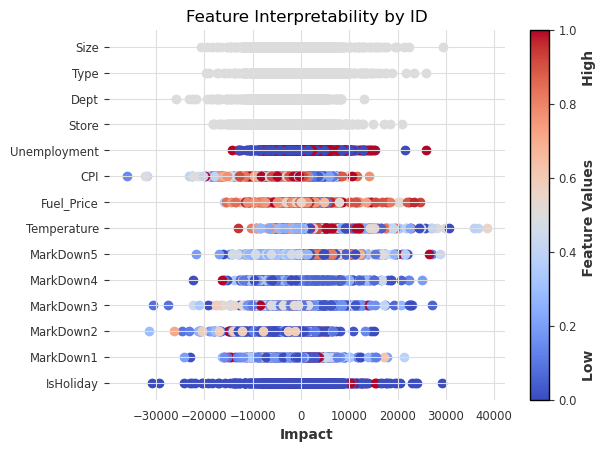

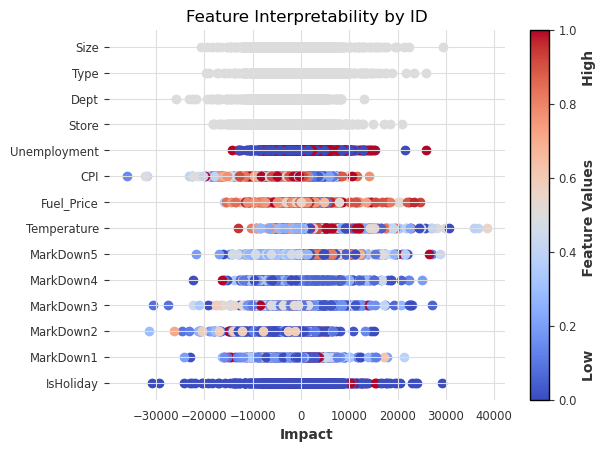

In [41]:
features = ['IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 
            'MarkDown5', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
            'Store','Dept','Type','Size']

summary_plot_serie(df_test,full_forecast_test,features,'Date',STATIC_COV)

In [42]:
new_df["trend_seasonality"] = new_df["forecast"] - new_df[STATIC_COV + DYNAMIC_COV_FILL_0 + DYNAMIC_COV_FILL_INTERPOLATE ].sum(axis=1)

In [43]:
forecast_df = new_df[new_df['id'] == '2-1']

dataframe_df = dataframe[dataframe['id'] == '2-1']

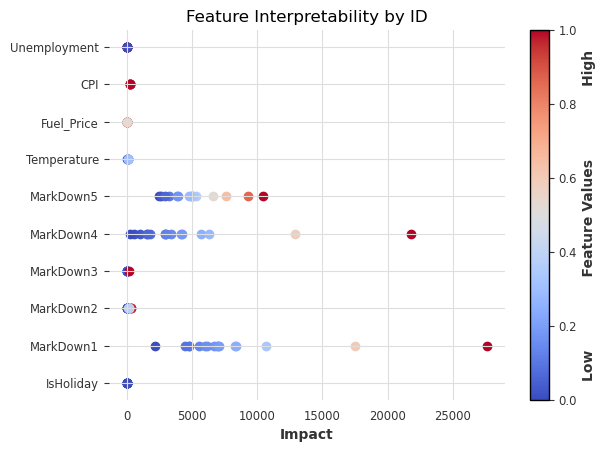

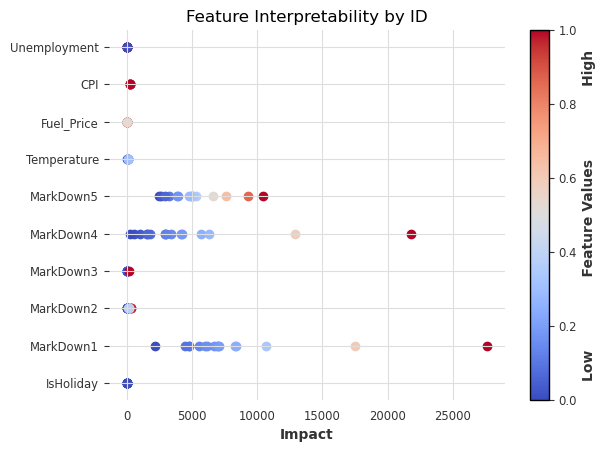

In [44]:
features = ['IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 
            'MarkDown5', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

summary_plot_serie(dataframe_df,dataframe_df,features,'Date',STATIC_COV)

In [45]:
forecast_df

,Date,id,forecast,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Temperature,Fuel_Price,CPI,Unemployment,Store,Dept,Type,Size,trend_seasonality
0,2012-07-13,2-1,23973.470615,-1069.204228,-651.624622,-133.520239,-1163.695912,-817.549055,-720.725573,-535.575802,-768.489836,-1608.175693,-362.691937,-1417.784734,-1232.702504,-1040.736541,-1234.179371,36730.126660
1,2012-07-20,2-1,23157.178215,-987.051403,10.367865,-364.538097,-1520.730183,-1241.759113,-689.882648,-512.840353,-39.515356,-1120.124966,-937.370983,-1604.047786,-1620.790551,-697.642234,-1555.091706,36038.195728
2,2012-07-27,2-1,23283.157431,-1331.654306,236.923771,-640.796155,-1077.589283,-516.462730,-406.054732,-54.937670,-53.937431,-661.363832,-234.718813,-1007.960326,-1503.725379,-500.456073,-1697.348770,32733.239159
3,2012-08-03,2-1,23441.719844,-1834.387437,260.374296,-417.226931,-1297.457072,-1325.476265,287.960998,1049.273600,-1141.191851,-1608.638405,131.018605,-1010.763567,-699.513621,-303.291789,-1683.592868,33034.632150
4,2012-08-10,2-1,24939.039303,-592.401944,590.466654,-573.546976,-595.257928,-404.384654,505.975580,154.551014,-465.273618,-1181.213250,1062.095489,-1484.688416,-1114.199271,-634.080401,-1742.118307,31413.115330
5,2012-08-17,2-1,25054.693966,711.427848,652.061636,196.165228,478.753412,917.792845,1507.832472,1291.807780,492.148729,-247.823352,1339.046464,-752.251420,-765.204769,78.640096,-967.793318,20122.090317
6,2012-08-24,2-1,28114.735939,-1617.523661,541.968905,-1498.148348,-1359.521776,-1443.854367,-1012.723106,626.188363,-1123.222534,-2071.640322,630.146605,-511.297188,-99.799845,1412.744234,693.319374,34948.099605
7,2012-08-31,2-1,25005.172083,-1208.223443,-324.301943,-1596.947364,125.956963,-1694.933259,-1033.070138,1578.087130,-2196.166373,-3149.670922,1104.322286,44.006026,-670.445710,71.700856,-47.801571,34002.659545
8,2012-09-07,2-1,30048.702824,2389.471543,1862.822330,347.558636,738.358000,959.901892,2066.966391,3593.848119,501.572484,-1131.448023,2971.912789,3096.296870,2557.781205,2870.382585,3502.235347,3721.042656
9,2012-09-14,2-1,26042.897767,1785.660884,524.605206,501.911626,1692.352197,913.247509,1213.498505,1637.541709,469.396973,-321.340462,1658.576724,1368.323396,140.189467,1765.730729,625.321771,12067.881531


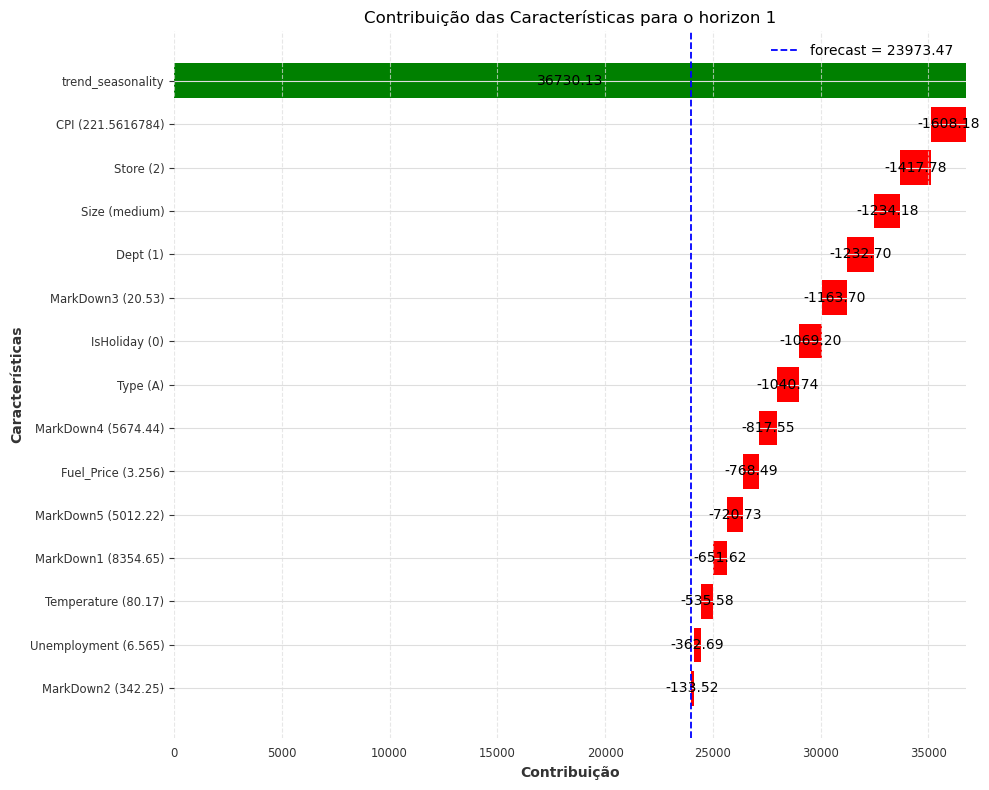

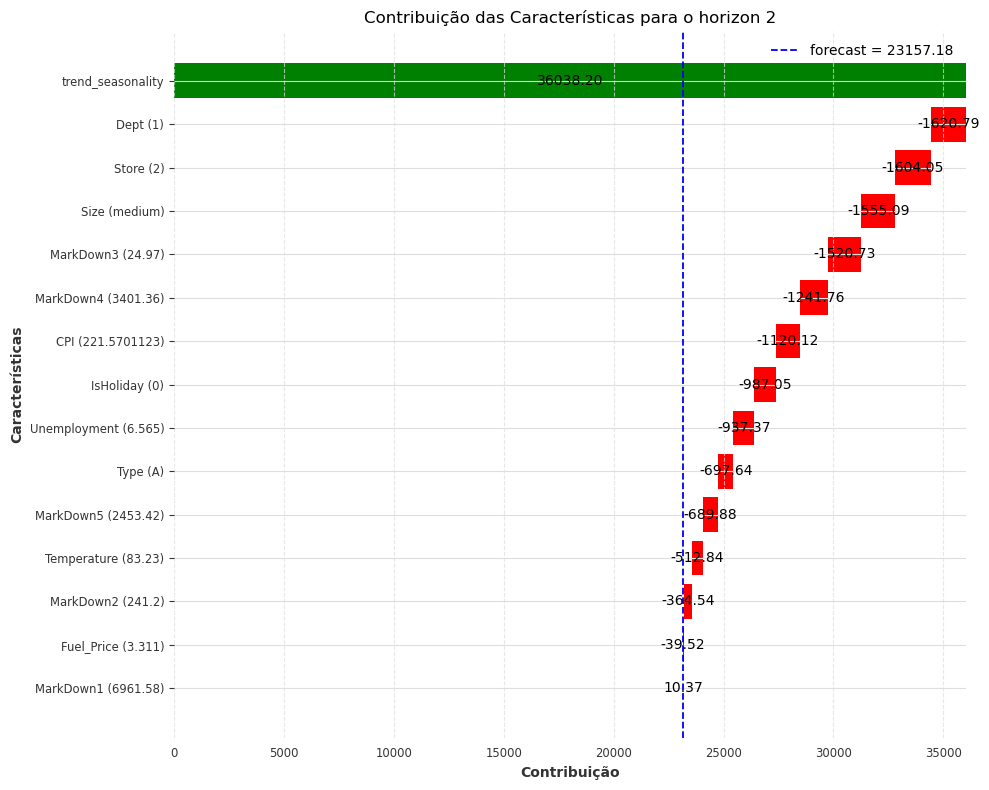

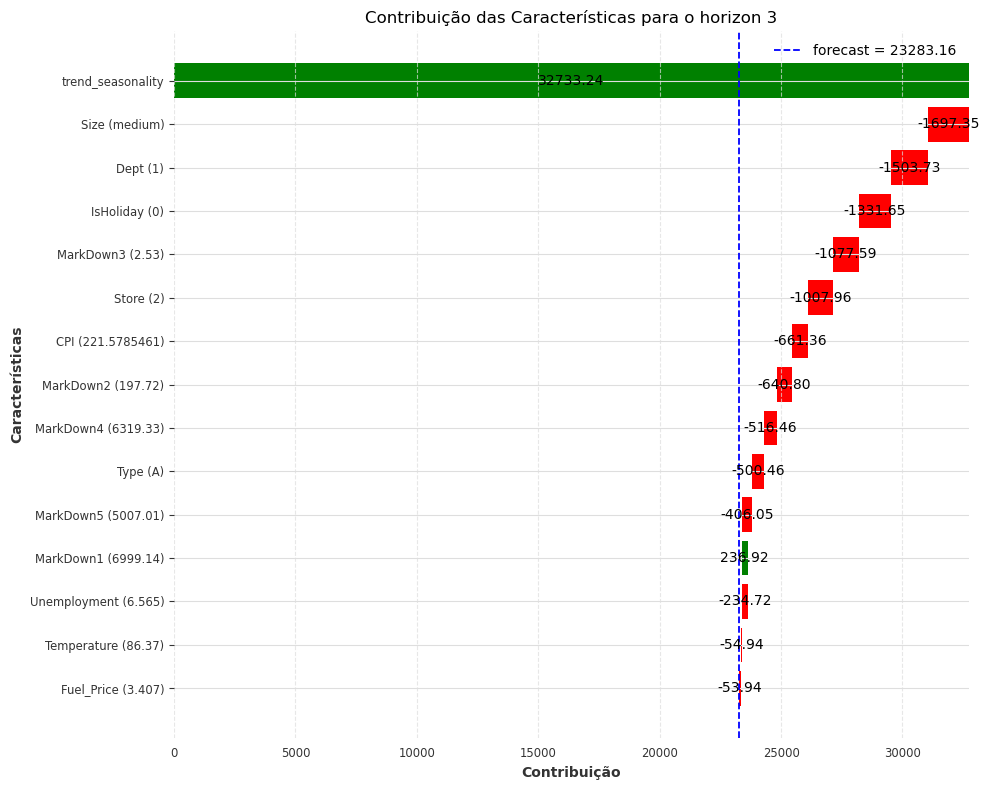

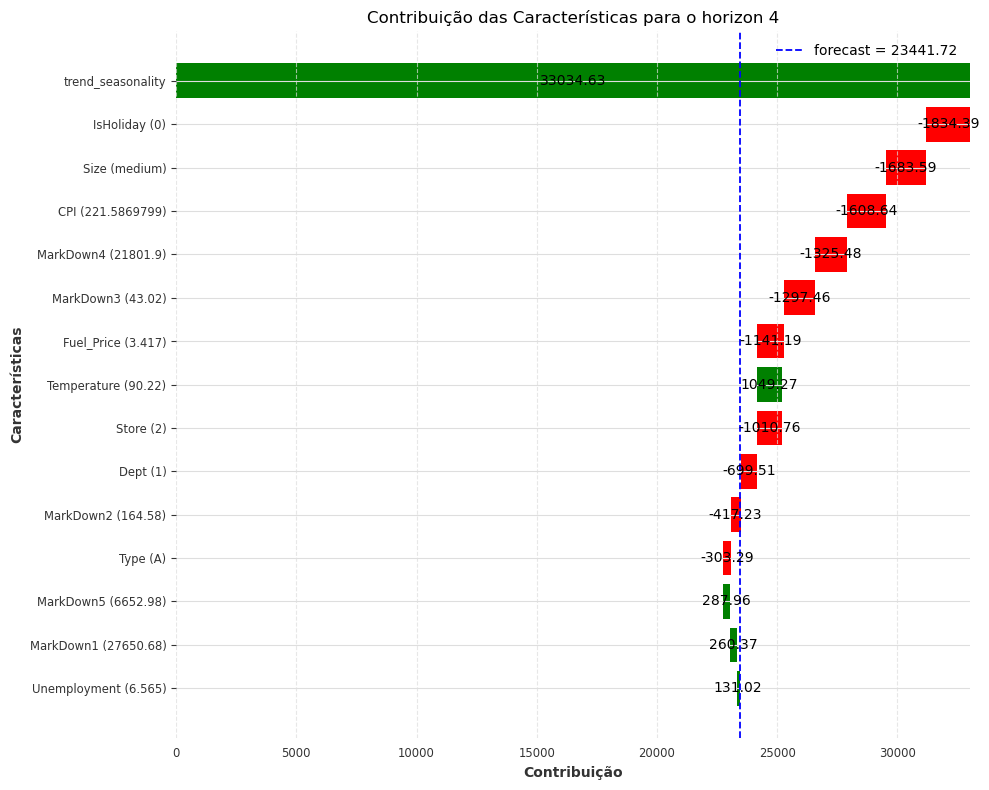

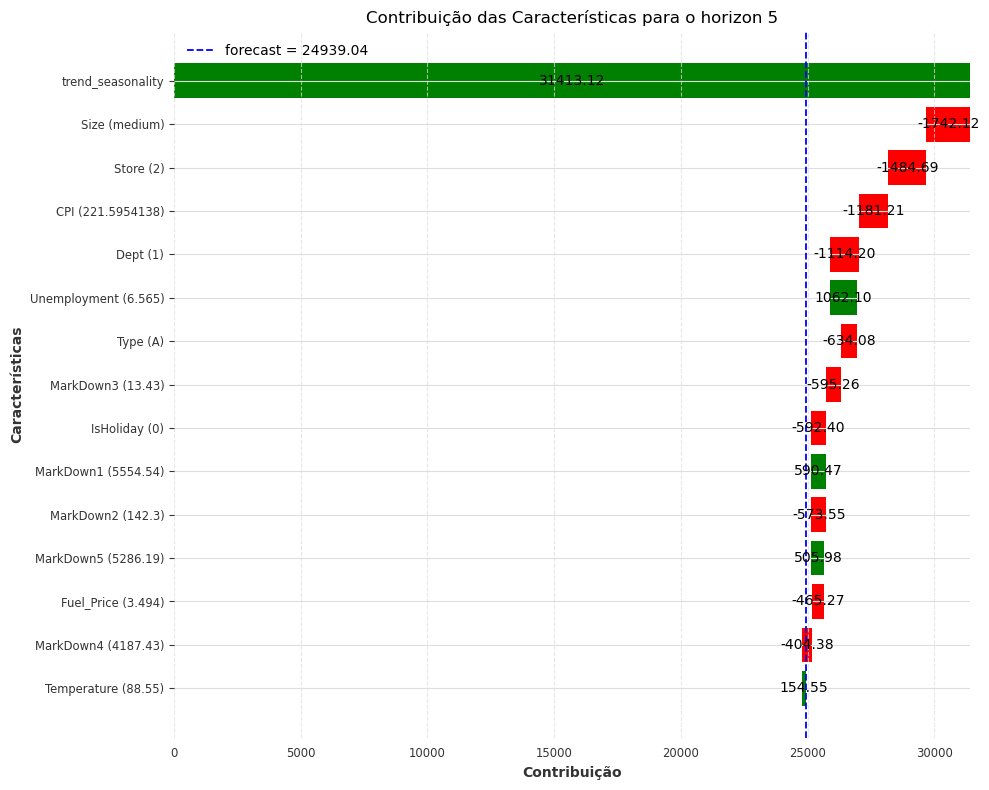

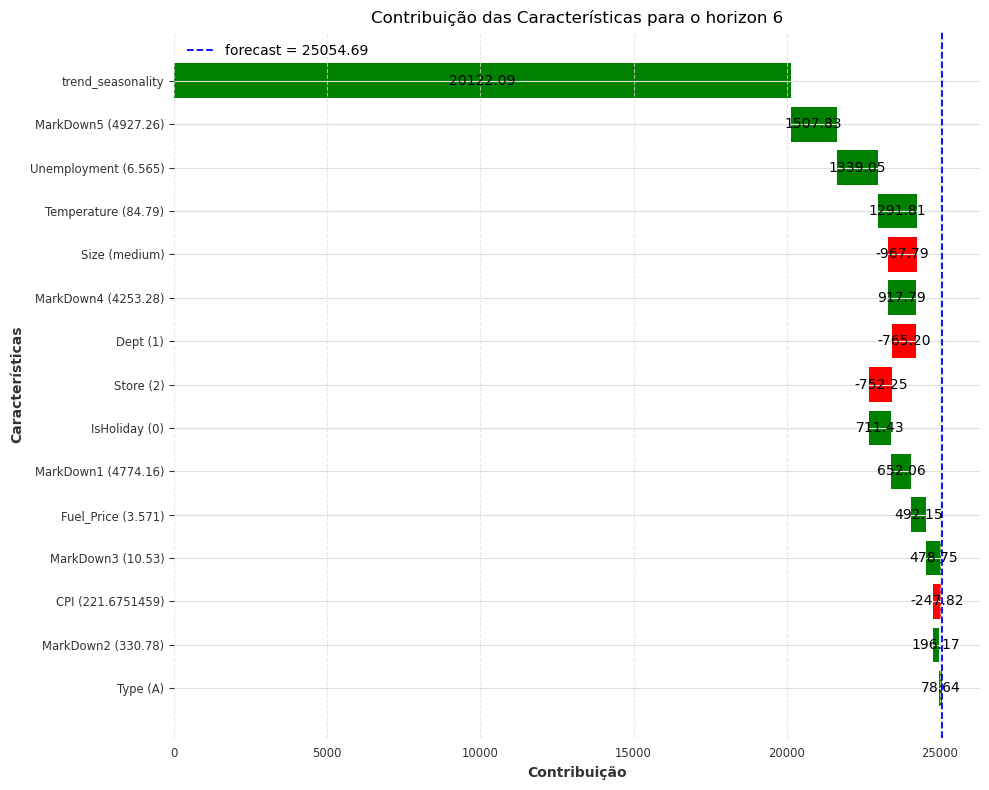

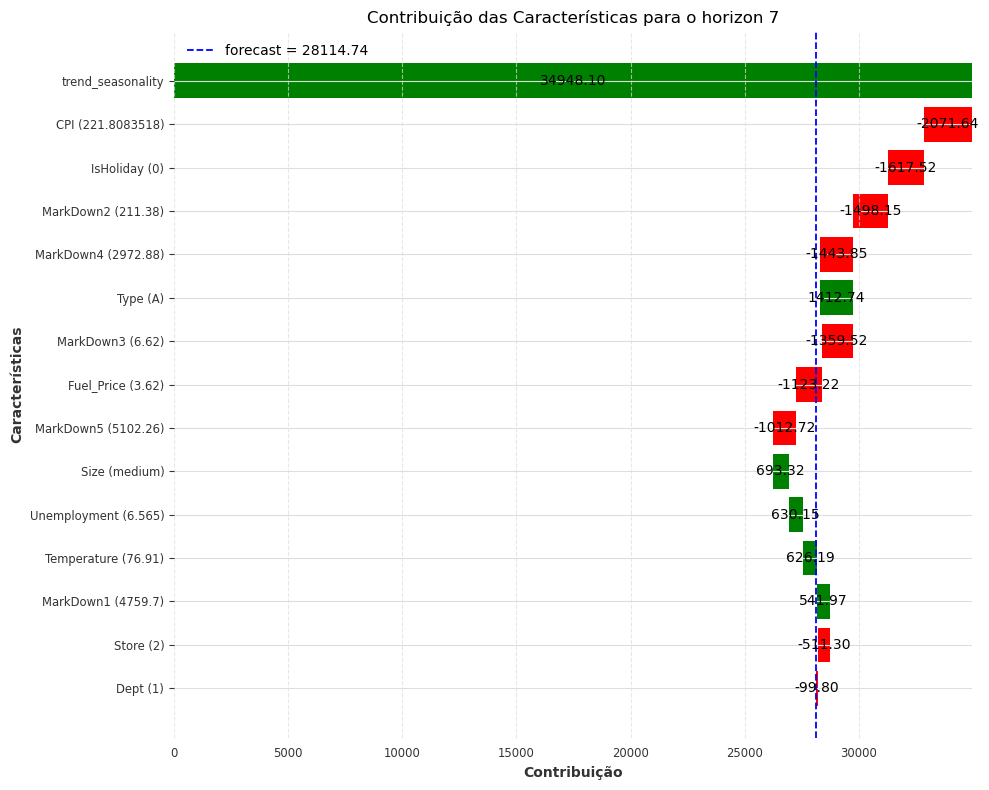

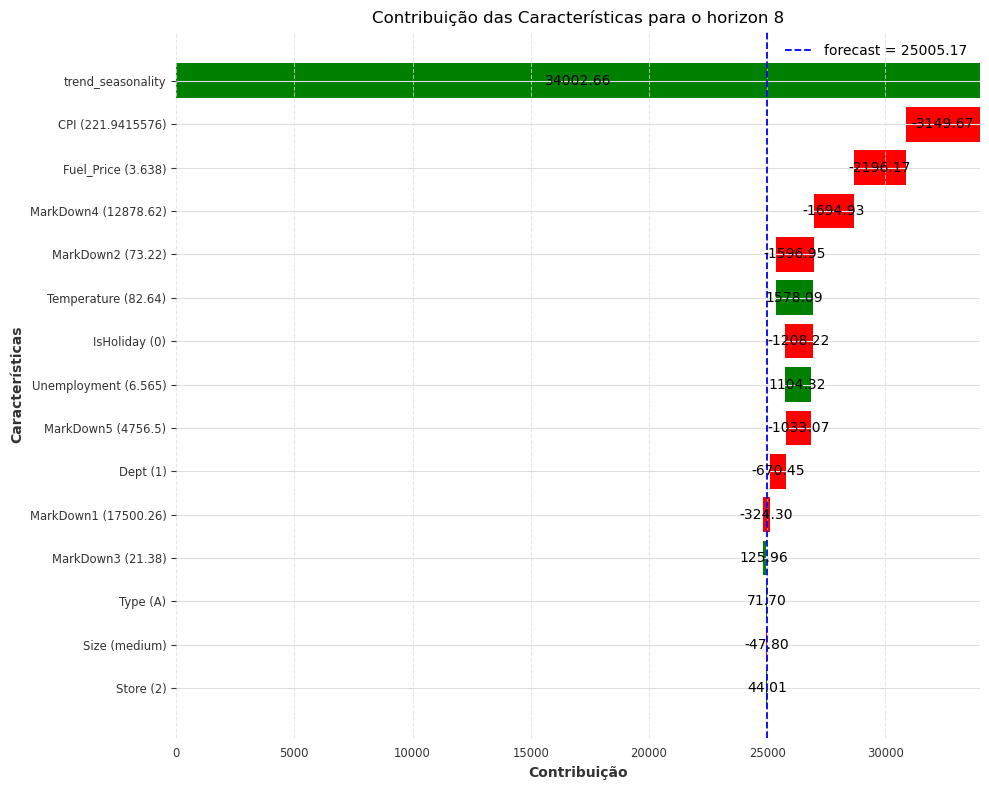

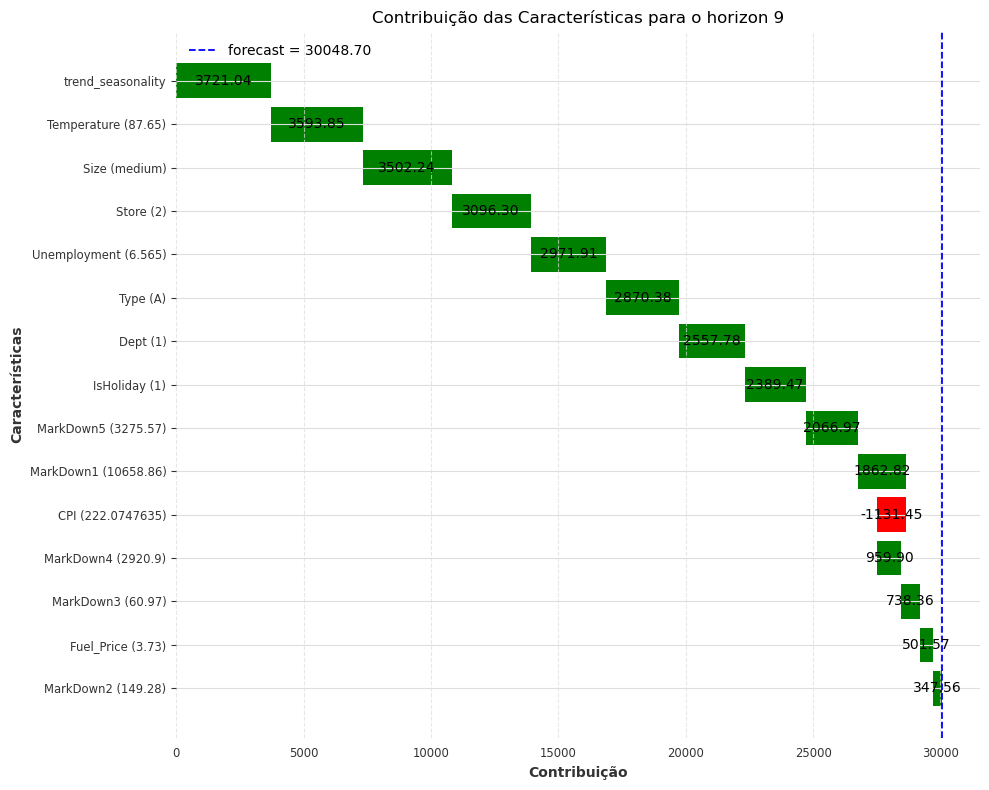

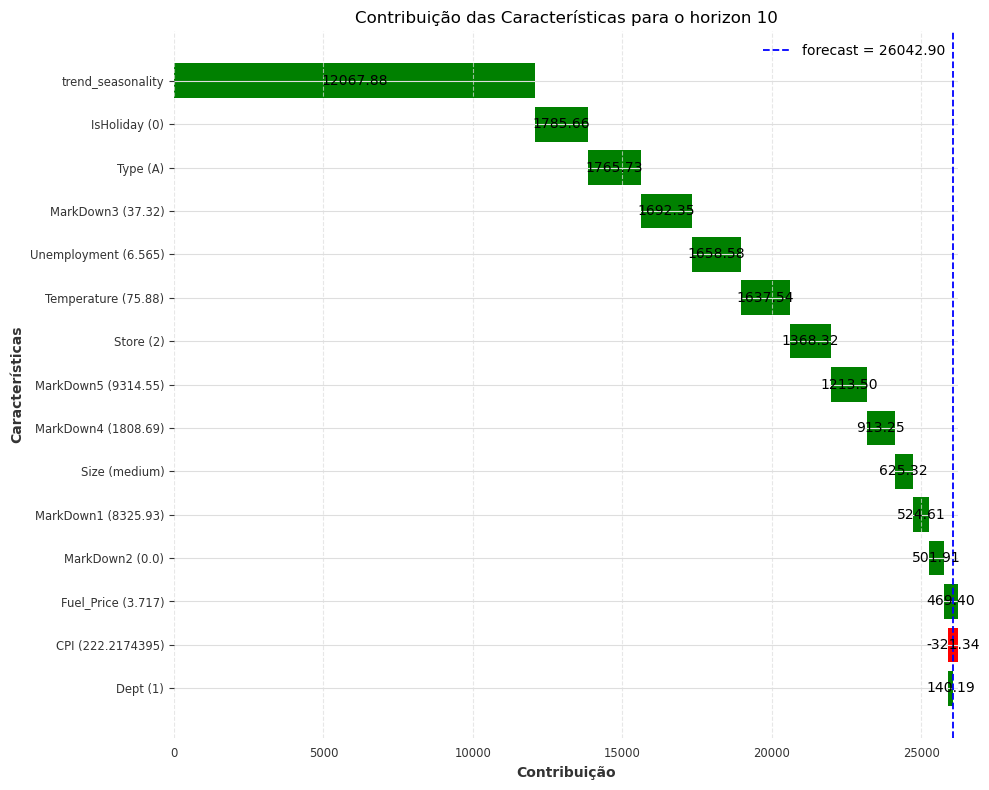

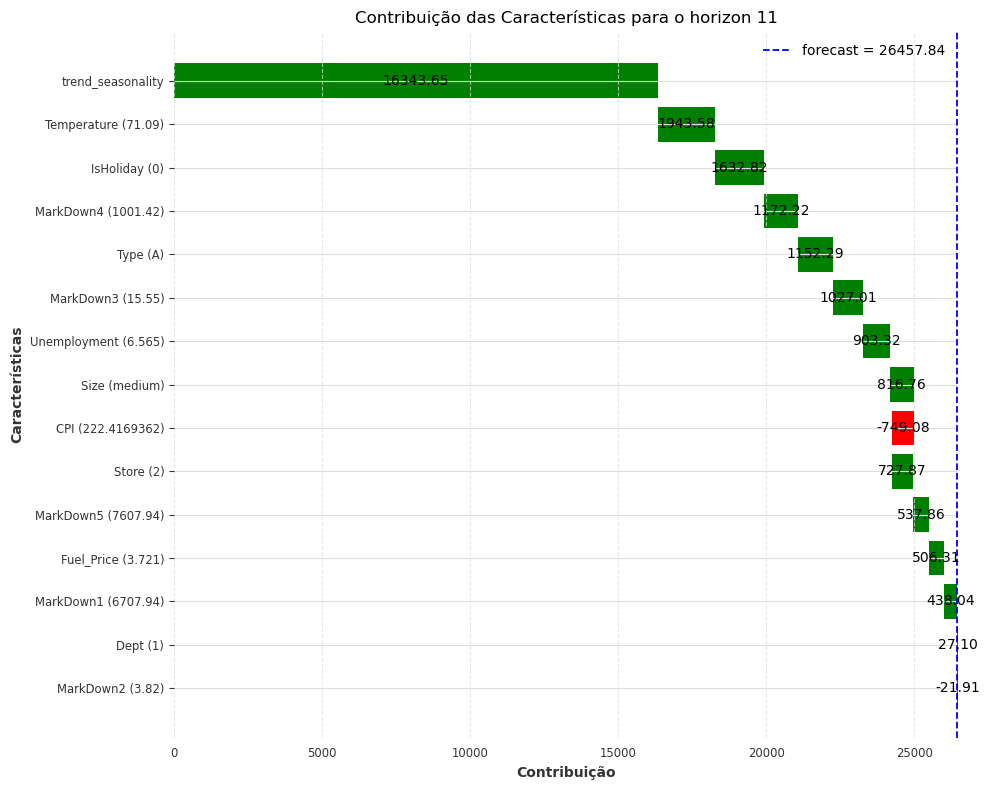

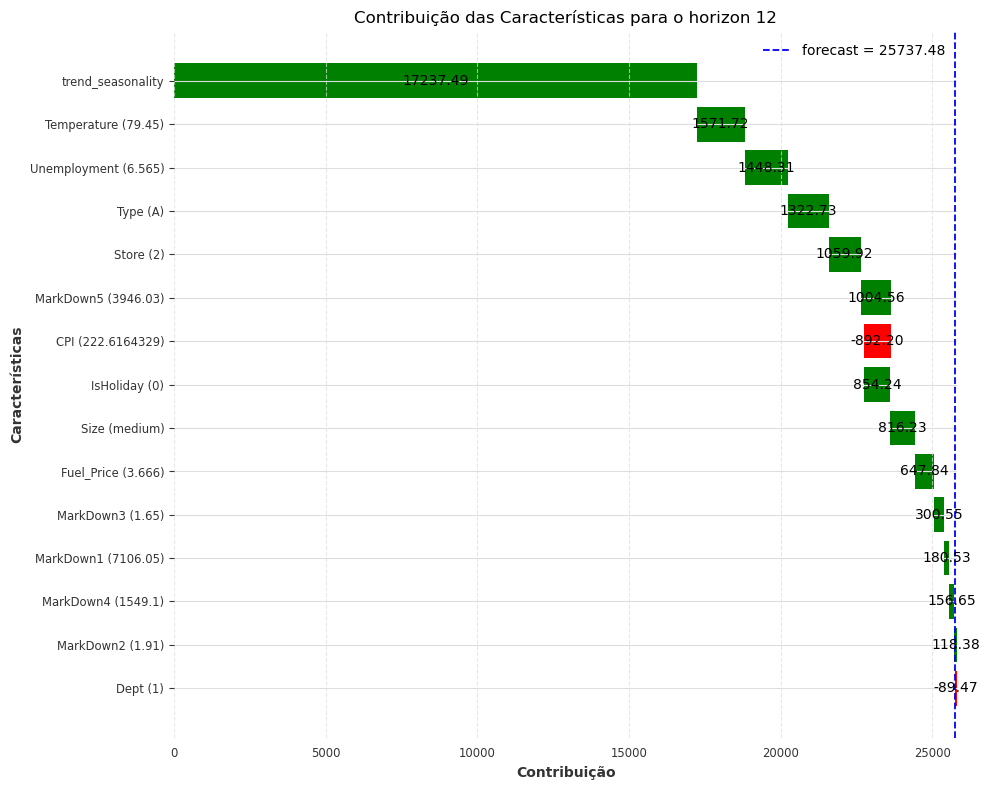

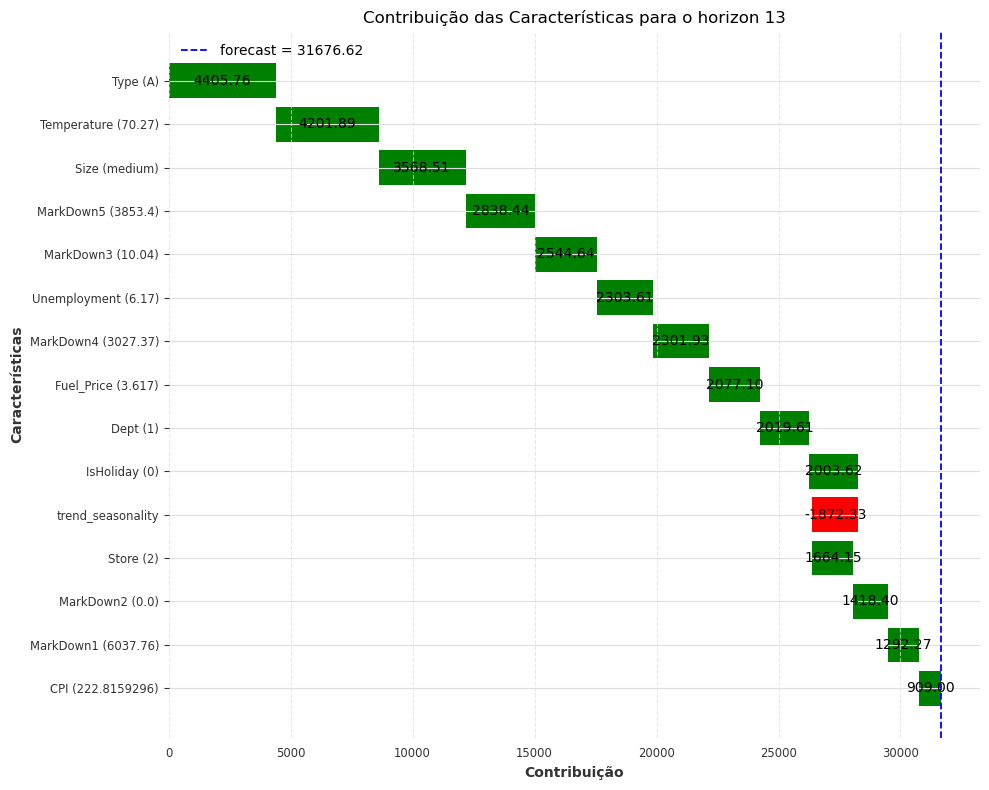

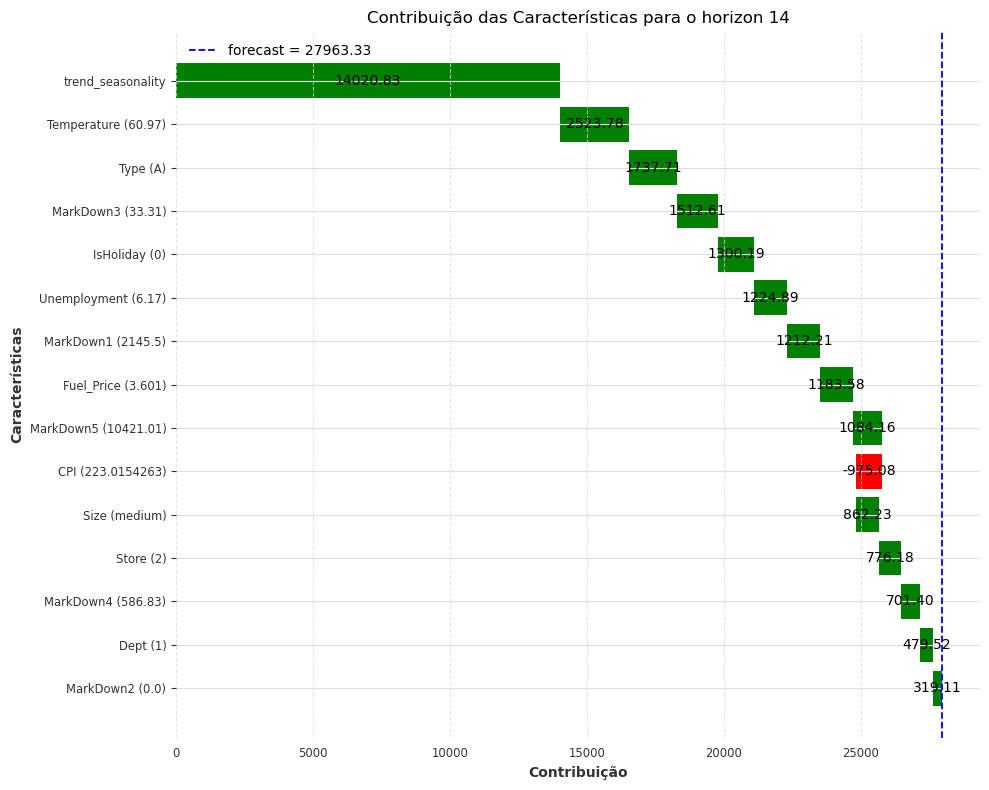

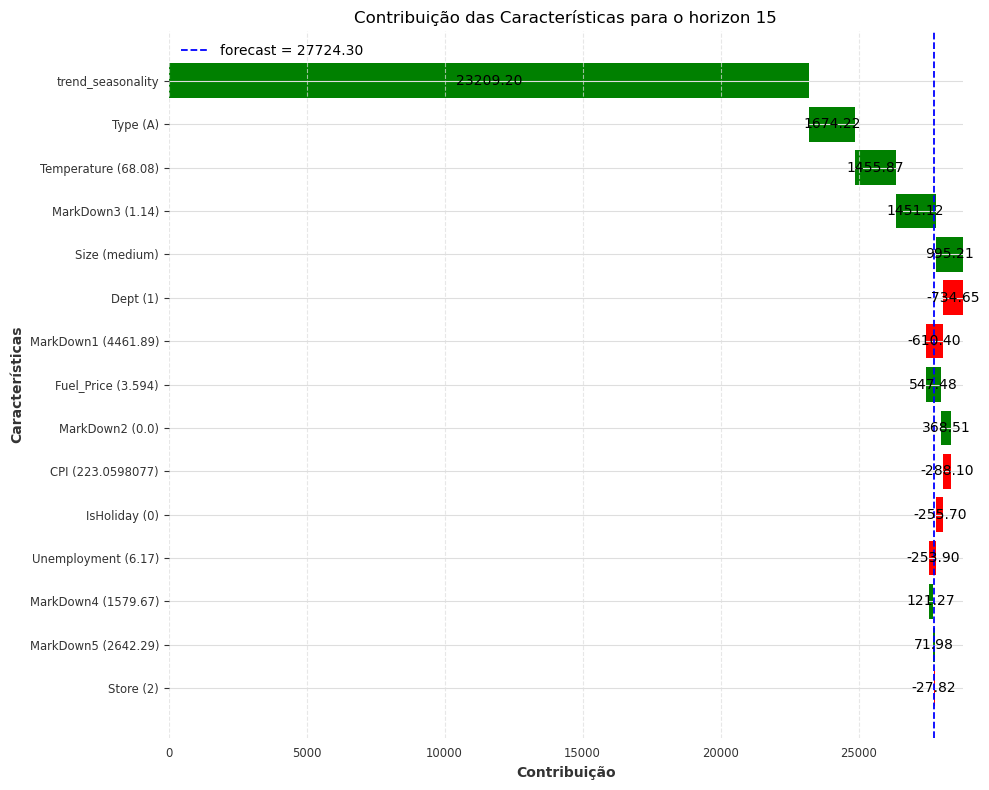

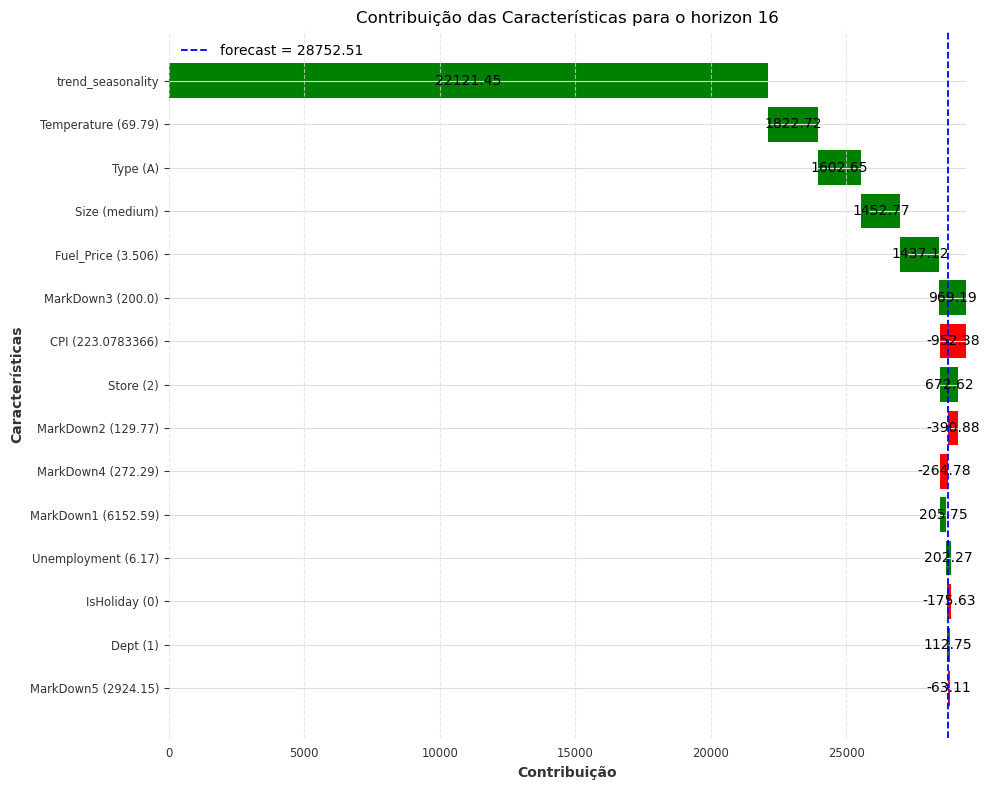

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

features = ['IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 
            'MarkDown5', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
            'Store', 'Dept', 'Type', 'Size','trend_seasonality']

last_16_forecast = forecast_df[features + ['forecast']]
last_16_future_dates = dataframe_df

i = 1
for (index_forecast, row_forecast), (index_future_dates, row_future_dates) in zip(last_16_forecast.iterrows(), last_16_future_dates.iterrows()):
    fig, ax = plt.subplots(figsize=(10, 8))

    contributions = {}
    for feature in features:
        contributions[feature] = row_forecast[feature]

    sorted_features = sorted(contributions, key=lambda x: abs(contributions[x]), reverse=True)

    bars = []
    lefts = [0]  # Ponto inicial para a primeira barra
    y_labels = []

    for feature in sorted_features:
        bars.append(contributions[feature])
        if feature in row_future_dates:
            y_labels.append(f"{feature} ({str(row_future_dates[feature])})")
        else:
            y_labels.append(feature)

    for idx in range(1, len(bars)):
        lefts.append(lefts[-1] + bars[idx-1])

    bars = np.array(bars)
    lefts = np.array(lefts)
    colors = ['green' if x >= 0 else 'red' for x in bars]

    bars = bars[::-1]
    lefts = lefts[::-1]
    y_labels = y_labels[::-1]
    colors = colors[::-1]

    ax.barh(y=y_labels, width=bars, left=lefts, color=colors)
    for j in range(len(bars)):
        ax.text(lefts[j] + bars[j] / 2, j, f'{bars[j]:.2f}', va='center', ha='center', color='black')
    ax.axvline(x=row_forecast['forecast'], color='blue', linestyle='--', label=f'forecast = {row_forecast["forecast"]:.2f}')
    ax.legend()
    ax.set_title(f"Contribuição das Características para o horizon {i}")
    ax.set_xlabel('Contribuição')
    ax.set_ylabel('Características')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    i += 1


In [47]:
from sklearn.metrics import mean_squared_error

real_values = dataframe['Weekly_Sales'].tolist()
predicted_values = new_df['forecast'].tolist()

rmse = mean_squared_error(real_values, predicted_values, squared=False)

print(f"RMSE no conjunto de teste total: {rmse}")


RMSE no conjunto de teste total: 7456.620785196708


In [48]:
from sklearn.metrics import mean_squared_error

real_values = dataframe_df['Weekly_Sales'].tolist()
predicted_values = forecast_df['forecast'].tolist()

rmse = mean_squared_error(real_values, predicted_values, squared=False)

print(f"RMSE no conjunto de teste para id='2-1': {rmse}")


RMSE no conjunto de teste para id='2-1': 4525.737335130232
